Training the network...
Epoch 0/1000 completed. Avg Error: 576230.383167381


<ipython-input-31-f5d2bb49ce06>:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 10/1000 completed. Avg Error: 224537.83497147757
Epoch 20/1000 completed. Avg Error: 224449.82924137227
Epoch 30/1000 completed. Avg Error: 224491.88182417615
Epoch 40/1000 completed. Avg Error: 224476.47728453096
Epoch 50/1000 completed. Avg Error: 224519.0571894893
Epoch 60/1000 completed. Avg Error: 224566.2802936285
Epoch 70/1000 completed. Avg Error: 224508.53279608535
Epoch 80/1000 completed. Avg Error: 224486.47070416165
Epoch 90/1000 completed. Avg Error: 224474.2039191522
Epoch 100/1000 completed. Avg Error: 224499.03591243425
Epoch 110/1000 completed. Avg Error: 224498.96536169402
Epoch 120/1000 completed. Avg Error: 224487.93308164048
Epoch 130/1000 completed. Avg Error: 224475.68647246566
Epoch 140/1000 completed. Avg Error: 224463.35715141852
Epoch 150/1000 completed. Avg Error: 224451.14258241694
Epoch 160/1000 completed. Avg Error: 224439.10105089418
Epoch 170/1000 completed. Avg Error: 224427.2539522468
Epoch 180/1000 completed. Avg Error: 224415.60941464486
Epoch

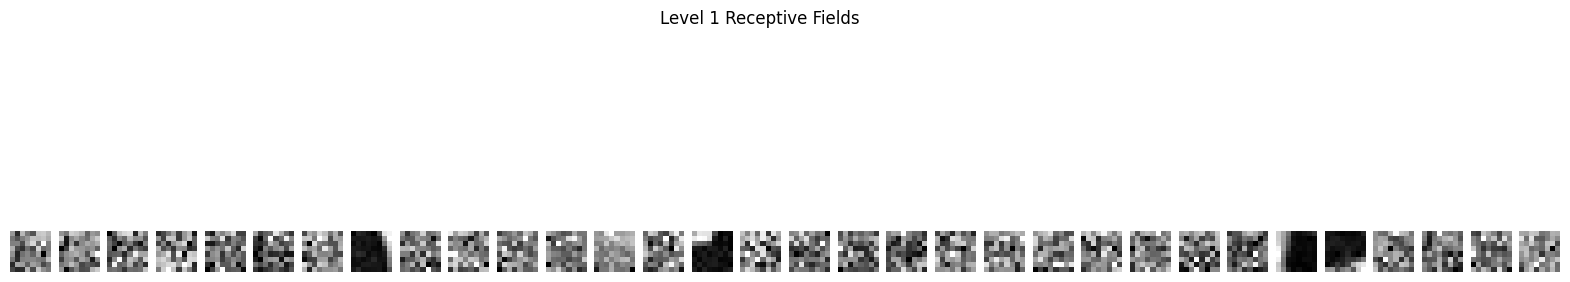

Visualizing the sparse receptive fields for level 1...


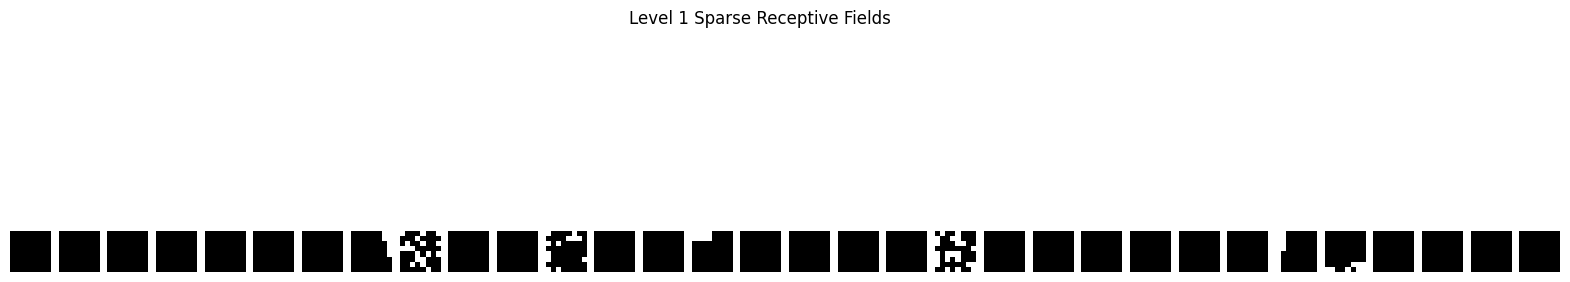

Plotting the training error...


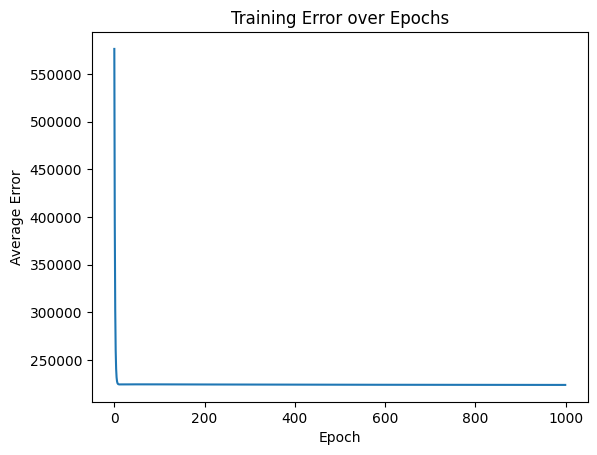

Creating bar images...
Visualizing prediction errors...


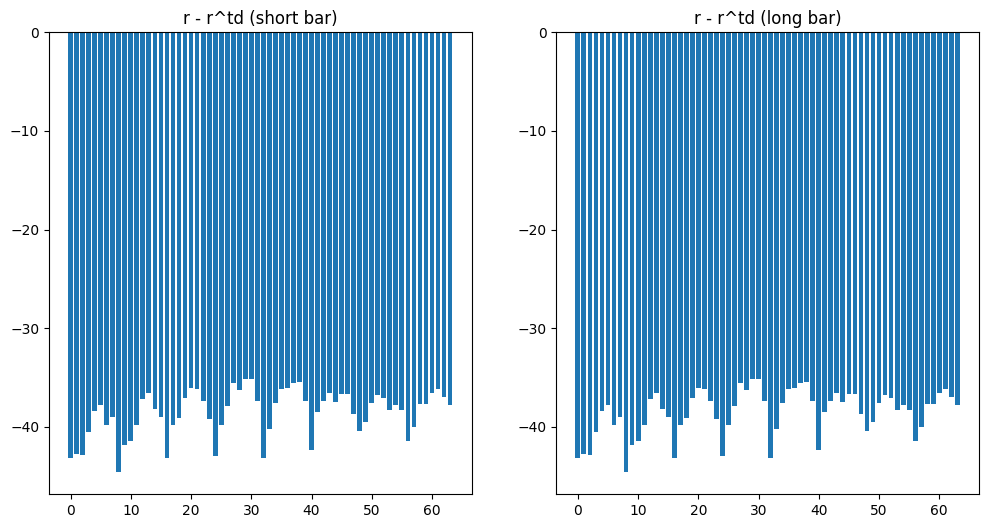

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Load sample images from local directory
def load_images(image_dir, image_size):
    images = []
    for filename in os.listdir(image_dir):
        if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg"):
            image = Image.open(os.path.join(image_dir, filename)).convert('L')
            image = image.resize((image_size, image_size))
            images.append(np.array(image))
    return np.array(images)

# Create bar images
def create_bar_images(image_size):
    long_bar = np.zeros((image_size, image_size))
    short_bar = np.zeros((image_size, image_size))

    long_bar[image_size // 2, :] = 1  # Horizontal long bar
    short_bar[image_size // 2, image_size // 4:image_size // 4 * 3] = 1  # Horizontal short bar

    return long_bar, short_bar

# Initialize the network
def initialize_network(input_size, hidden_size):
    U = np.random.randn(hidden_size, input_size)
    return U

# Forward pass to get predictions
def forward(U, x):
    return sigmoid(np.dot(U, x))

# Compute error
def compute_error(I, I_pred):
    return I - I_pred

# Update weights using gradient descent with sparsity
def update_weights(U, I, I_pred, r, k2, sigma2, lambd, sparse_penalty):
    error = compute_error(I, I_pred)
    dU = k2 * (np.outer(error, r) / sigma2 - lambd * U.T - sparse_penalty * np.sign(U.T))
    U += dU.T
    return U, np.sum(error ** 2)

# Extract patches from images
def extract_patches(images, patch_size):
    patches = []
    for image in images:
        for i in range(0, image.shape[0] - patch_size + 1, patch_size):
            for j in range(0, image.shape[1] - patch_size + 1, patch_size):
                patch = image[i:i+patch_size, j:j+patch_size].flatten()
                patches.append(patch)
    return np.array(patches)

# Train the network
def train_network(images, patch_size, hidden_size1, hidden_size2, epochs, k2, sigma2, lambd, sparse_penalty):
    patches = extract_patches(images, patch_size)
    input_size = patches.shape[1]

    U1 = initialize_network(input_size, hidden_size1)
    U2 = initialize_network(hidden_size1, hidden_size2)
    errors = []

    for epoch in range(epochs):
        epoch_error = 0
        for patch in patches:
            # Level 1
            r1 = forward(U1, patch)
            I_pred1 = np.dot(U1.T, r1)
            U1, patch_error1 = update_weights(U1, patch, I_pred1, r1, k2, sigma2, lambd, sparse_penalty)

            # Level 2
            r2 = forward(U2, r1)
            I_pred2 = np.dot(U2.T, r2)
            U2, patch_error2 = update_weights(U2, r1, I_pred2, r2, k2, sigma2, lambd, sparse_penalty)

            epoch_error += patch_error1 + patch_error2

        errors.append(epoch_error / len(patches))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} completed. Avg Error: {errors[-1]}")

    return U1, U2, errors

# Visualize receptive fields
def visualize_receptive_fields(U, level, hidden_size, patch_size):
    fig, axes = plt.subplots(1, hidden_size, figsize=(20, 5))
    for i in range(hidden_size):
        ax = axes[i]
        if U[i].size == patch_size * patch_size:
            ax.imshow(U[i].reshape(patch_size, patch_size), cmap='gray')
        else:
            ax.text(0.5, 0.5, 'Invalid size', ha='center', va='center', color='red')
        ax.axis('off')
    plt.suptitle(f'Level {level} Receptive Fields')
    plt.show()

# Visualize receptive fields with sparse prior
def visualize_sparse_receptive_fields(U, level, hidden_size, patch_size):
    fig, axes = plt.subplots(1, hidden_size, figsize=(20, 5))
    for i in range(hidden_size):
        ax = axes[i]
        if U[i].size == patch_size * patch_size:
            ax.imshow(np.sign(U[i]).reshape(patch_size, patch_size), cmap='gray')
        else:
            ax.text(0.5, 0.5, 'Invalid size', ha='center', va='center', color='red')
        ax.axis('off')
    plt.suptitle(f'Level {level} Sparse Receptive Fields')
    plt.show()

# Plot error over epochs
def plot_errors(errors):
    plt.figure()
    plt.plot(errors)
    plt.xlabel('Epoch')
    plt.ylabel('Average Error')
    plt.title('Training Error over Epochs')
    plt.show()

# Visualize prediction errors as bar plots
def visualize_prediction_errors(U1, long_bar, short_bar, patch_size):
    long_bar_patches = extract_patches(np.array([long_bar]), patch_size)
    short_bar_patches = extract_patches(np.array([short_bar]), patch_size)

    long_bar_r1 = forward(U1, long_bar_patches[0])
    short_bar_r1 = forward(U1, short_bar_patches[0])

    # Compute top-down predictions
    long_bar_pred_td = np.dot(U1.T, long_bar_r1)
    short_bar_pred_td = np.dot(U1.T, short_bar_r1)

    # Compute prediction errors (input - reconstructed input)
    long_bar_pred_error = long_bar_patches[0] - long_bar_pred_td
    short_bar_pred_error = short_bar_patches[0] - short_bar_pred_td

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].bar(range(len(short_bar_pred_error)), short_bar_pred_error.flatten())
    axes[0].set_title('r - r^td (short bar)')
    axes[1].bar(range(len(long_bar_pred_error)), long_bar_pred_error.flatten())
    axes[1].set_title('r - r^td (long bar)')
    plt.show()


def main():
    image_dir = '/content/data'  # Update this path to your local images directory
    image_size = 64  # Resize images to this size
    patch_size = 8  # Size of each patch
    hidden_size1 = 32  # Number of hidden neurons in level 1
    hidden_size2 = 32  # Number of hidden neurons in level 2
    epochs = 1000
    k2 = 0.00005  # Learning rate
    sigma2 = 1  # Variance
    lambd = 0.1  # Regularization parameter
    sparse_penalty = 0.0001  # Sparsity penalty

    images = load_images(image_dir, image_size)
    if len(images) < 5:
        print("Please make sure there are at least 5 images in the directory.")
        return

    print("Training the network...")
    U1, U2, errors = train_network(images, patch_size, hidden_size1, hidden_size2, epochs, k2, sigma2, lambd, sparse_penalty)

    print("Visualizing the receptive fields for level 1...")
    visualize_receptive_fields(U1, level=1, hidden_size=hidden_size1, patch_size=patch_size)

    print("Visualizing the sparse receptive fields for level 1...")
    visualize_sparse_receptive_fields(U1, level=1, hidden_size=hidden_size1, patch_size=patch_size)

    print("Plotting the training error...")
    plot_errors(errors)

    print("Creating bar images...")
    long_bar, short_bar = create_bar_images(image_size)

    print("Visualizing prediction errors...")
    visualize_prediction_errors(U1, long_bar, short_bar, patch_size)

if __name__ == "__main__":
    main()
